### 从零开始实现线性回归

In [1]:
%matplotlib inline
import random
import torch
import d2l

根据带有噪声的线性模型构造一个人造数据集，使用参数$W=[2, -3.4]^T$、$b=4.2$和噪声项$\epsilon$生成数据集和标签：
$$
y=XW+b+\epsilon
$$

In [2]:
def synthetic_data(w, b, num_examples):
    # 生成y = Xw + b + 噪声
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X,w) + b
    y += torch.normal(0, 0.01, y.shape)
    # 注意这里的reshape参数为-1表示我只指定列数为1，多少行由框架给我计算
    return X, y.reshape((-1, 1))

In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.5147, -0.3237]) 
label: tensor([4.2847])


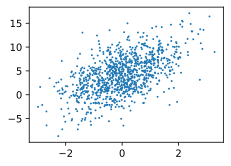

In [5]:
d2l.set_figsize()
# 取features第1列数据，因为对应W正数，正相关
d2l.plt.scatter(features[:, 0].detach().numpy(), labels.detach().numpy(), 1)

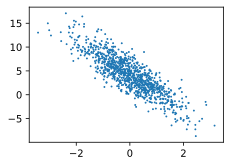

In [6]:
d2l.set_figsize()
# 取features第2列数据，因为对应W负数，负相关
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

定义一个`data_iter`函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

In [7]:
def data_iter(batch_size, features, y):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 打乱
    random.shuffle(indices)
    # 从0开始，到num_examples为止，每次间隔为batchsize
    for i in range(0, num_examples, batch_size):
        batch_indices = indices[i:min(i+batch_size, num_examples)]
        yield features[batch_indices], labels[batch_indices]

In [8]:
batch_size = 10
# 测试iter
for X, y in data_iter(batch_size, features, labels):
    print('X:',X)
    print('y',y)
    break

X: tensor([[-0.5261, -0.3241],
        [-2.3317, -0.8737],
        [ 0.6960, -1.4741],
        [-0.1154, -0.7753],
        [-0.1834,  1.7327],
        [ 1.0455, -0.0480],
        [ 0.7069,  0.1792],
        [-0.3472,  0.5839],
        [-0.4418, -0.8146],
        [-1.3479,  0.3991]])
y tensor([[ 4.2444],
        [ 2.5103],
        [10.6005],
        [ 6.6218],
        [-2.0752],
        [ 6.4610],
        [ 5.0297],
        [ 1.5267],
        [ 6.0719],
        [ 0.1490]])


定义初始化模型参数

In [9]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [10]:
def linreg(X, w, b):
    # 线性回归
    return torch.matmul(X, w)+b

定义损失函数

In [11]:
def squared_loss(y_hat, y):
    # 均方差
    return torch.sum((y_hat - y.reshape(y_hat.shape))**2) / (2*torch.numel(y))

In [12]:
def minibatchSGD(params, lr):
    # 小批量随机梯度下降
    # 参数更新时不参与梯度计算
    with torch.no_grad():
        for param in params:
            param -= lr*param.grad
            # 梯度清零
            param.grad.zero_()

训练过程

In [13]:
# 定义学习率
lr = 0.03
# 训练轮数3
num_epochs = 3
# 线性回归模型
net = linreg
# 均方误差
loss = squared_loss

for epoch in range(num_epochs):
    # 取出训练数据
    for X, y in data_iter(batch_size, features, labels):
        # 计算loss
        l = loss(net(X, w, b), y)
        # 反向传播
        l.backward()
        # SGD
        minibatchSGD([w, b], lr)
        # 显示训练信息
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print('epoch: {}, loss={}'.format(epoch+1, train_l))
    

epoch: 1, loss=0.0381179042160511
epoch: 2, loss=0.00014650175580754876
epoch: 3, loss=5.115706517244689e-05


### 线性回归的简洁实现

In [14]:
import numpy as np
import torch
from torch.utils import data
import d2l

In [15]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

调用框架中的现有API来读取数据

In [16]:
# 加载数据
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个pytorch数据迭代器"""
    # 注意这里的*表达式，表示将元组"解开"
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [17]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[-1.4760, -0.2664],
         [ 1.1684, -0.4854],
         [-1.3046, -0.6664],
         [-0.2546, -0.7079],
         [-0.4909,  1.1011],
         [-1.0518, -0.1792],
         [ 1.5046, -0.4508],
         [-0.7639,  1.7440],
         [-2.4727, -0.3734],
         [-1.3917,  0.3587]]), tensor([[ 2.1640],
         [ 8.1757],
         [ 3.8506],
         [ 6.0892],
         [-0.5230],
         [ 2.6927],
         [ 8.7466],
         [-3.2452],
         [ 0.5058],
         [ 0.1945]])]

使用框架的预定义好的层

In [18]:
# 'nn'是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

初始化模型参数

In [19]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

计算均方误差使用的是MSELOSS类，也称为平方L2范数

In [20]:
loss = nn.MSELoss()

实例化SGD实例

In [21]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

训练过程代码与我们从零开始实现时做的类似

In [22]:
# 设置epoch=3
num_eoochs = 3
for epoch in range(num_eoochs):
    # 取出数据
    for X, y in data_iter:
        l = loss(net(X), y)
        # 梯度清零
        trainer.zero_grad()
        # 反向传播
        l.backward()
        # 执行一次更新
        trainer.step()
    # 测试
    l = loss(net(features), labels)
    print('epoch: {}, loss = {}'.format(epoch, l))

epoch: 0, loss = 0.00029607079341076314
epoch: 1, loss = 0.00010197521623922512
epoch: 2, loss = 0.00010124435357283801
